In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

energy_grad = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_features_energygrad.txt')
geo_topo = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_features_geo_topo.txt')
other = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_features_otherinfo.txt')
mig = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_features_mig.csv')
da = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190425_features_dihedral_ang.txt')

# mig_sign.columns = mig_sign.columns.str.strip()
energy_grad.columns = energy_grad.columns.str.strip()
geo_topo.columns = geo_topo.columns.str.strip()
other.columns = other.columns.str.strip()
mig.columns = mig.columns.str.strip()
da.columns = da.columns.str.strip()

geo_topo = geo_topo.astype('float')
other = other.astype('float')
da = da.astype('float')

da_len = pd.concat([da.iloc[:,:3], da.iloc[:,6:9]], axis=1)
da_num = pd.concat([da.iloc[:,3:6], da.iloc[:,9:]], axis=1)

In [10]:
neigh_pos_frac = pd.read_csv('/Users/xiaotingzhong/Desktop/Datas/Ni_an4_5/data_matlab/190531_neighfrac_pos_an4.txt', names=['neigh_pos_frac'])
geo_topo = pd.concat([geo_topo, neigh_pos_frac], axis=1)
geo_topo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6942 entries, 0 to 6941
Data columns (total 13 columns):
A_an4                6942 non-null float64
fMs_an4              6942 non-null float64
avg_FabsavgH_an4     6939 non-null float64
C_an4                6942 non-null float64
CnnC_an4             6942 non-null float64
A_diff               6942 non-null float64
fMs_diff             6942 non-null float64
avg_FabsavgH_diff    6937 non-null float64
C_diff               6942 non-null float64
CnnC_diff            6940 non-null float64
nnG_favg_diff        6942 non-null float64
nnG_fmax_diff        6942 non-null float64
neigh_pos_frac       6942 non-null float64
dtypes: float64(13)
memory usage: 705.1 KB


In [11]:
def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          rotate_xlabel=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    if rotate_xlabel:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    # save figure
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")
    
    return ax


def plotCorrelationMatrix(df, title=None):
    # Create Correlation df
    corr = df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(36, 36))

    # Drop self-correlations
    dropSelf = np.zeros_like(corr)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    # Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap="Blues", annot=True, fmt=".2f", mask=dropSelf, square=True)
    # Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns, size = 16)
    # Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns, size = 16)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # save figure
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")
    
    # show plot
    plt.show()

    
def plotFeatureImportance(feature_importance, names, title = None):
    fig, ax = plt.subplots(figsize=(15, 6))
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.yticks(fontsize=16)
    plt.xticks(range(len(feature_importance)), names.values, size = 16)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")

def plotForwardSelection(train_score, test_score, feature_names, title=None):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()

    x_axis = np.arange(len(train_score))+1
    ax1.plot(x_axis, train_score, '-o', color = 'k', label='train')
    ax1.plot(x_axis, test_score, '-o', color = 'r', label='test')
    ax1.set_xlabel('$\#$ Features',  usetex=True, size=16)
    ax1.set_ylabel('Ajusted $R^2$', usetex=True, size=16)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(x_axis)
    ax2.set_xticklabels(feature_names)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="left",
             rotation_mode="anchor")
    ax1.legend()
    
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")
        
    # plt.ylim((0, 0.3)) 
    plt.show()
    

### EDA
- If using dihedral angles, then need to filter out nans

In [13]:
# # ------------------------------ migration direction from Δ(centroid) ------------------------------
# dist_f_g_an4 = mig['dists_f_g_an4_l']
# dist_f_g_an5 = mig['dists_f_g_an5_l']

# eps_motion = 0.005;
# move_left = np.zeros([mig.shape[0], 1]);
# mask_left = dist_f_g_an4 < dist_f_g_an5 - eps_motion;
# mask_right = dist_f_g_an4 > dist_f_g_an5 + eps_motion
# move_left[mask_left] = 1;
# move_left[mask_right] = -1;

# da_len.iloc[:,:3] -= 120.0 
# data = pd.concat([geo_topo.iloc[:,[0,1,2,5,6,7]], geo_topo.iloc[:,[10,11,3,4,8,9]], da_len, other], axis=1)
# data.columns = np.insert(data.columns[1:].values, [0], 'mig_left')
# data = data.mask(~other['not_twin_an4'].astype(bool))

data = geo_topo
data = data.dropna()
data.info()


# data_normed =  data / data.max(axis=0) * 10
# plotCorrelationMatrix(data_normed, 'corr')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6932 entries, 0 to 6941
Data columns (total 13 columns):
A_an4                6932 non-null float64
fMs_an4              6932 non-null float64
avg_FabsavgH_an4     6932 non-null float64
C_an4                6932 non-null float64
CnnC_an4             6932 non-null float64
A_diff               6932 non-null float64
fMs_diff             6932 non-null float64
avg_FabsavgH_diff    6932 non-null float64
C_diff               6932 non-null float64
CnnC_diff            6932 non-null float64
nnG_favg_diff        6932 non-null float64
nnG_fmax_diff        6932 non-null float64
neigh_pos_frac       6932 non-null float64
dtypes: float64(13)
memory usage: 758.2 KB


# Linear Regression
- Best Subset, Forward Selection, or Lasso? (Ryan J. Tibshirani)
    - Best subset selection and forward selection usually perform similarly.
    - Lasso is preferred if low signal-to-noise ratio (SNR); Best subset if high SNR.

### Linear Regression, Vanilla
- adjusted R2 https://xavierbourretsicotte.github.io/subset_selection.html

In [4]:
# import statsmodels.api as sm
# from sklearn.metrics import r2_score

# # ----- normalization -----
# data =  data / data.max(axis=0) * 10

# # ----- X & y -----
# X = data.drop(['A_diff', 'fMs_diff'], axis=1)
# y = np.abs(data['A_diff'])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# ----- fit model -----
# X_train = sm.add_constant(X_train) # adding a constant
# X_test = sm.add_constant(X_test)
# X = sm.add_constant(X)
# model = sm.OLS(y_train, X_train).fit()
X_train_selected = sm.add_constant(X_train[selected])
X_test_selected = sm.add_constant(X_test[selected])
model = sm.OLS(y_train, X_train_selected).fit()

# ----- print results -----
predictions = model.predict(X_test_selected) 
r2_test = r2_score(y_test, predictions)
m = float(X_test.shape[0])
k = float(X_test.shape[1])
r2_adjusted_test = 1 - (1-r2_test)*((m-1)/(m-k-1))
print r2_test
print r2_adjusted_test

model.summary()





### Linear Regression, Lasso

In [20]:
from sklearn.linear_model import Lasso

# y = energy_grad.iloc[:, 0]
# X = energy_grad.iloc[:, 1:]

# ----- entire data -----
# y = np.abs(data['A_diff'])
# X = data.drop(['A_diff', 'fMs_diff'], axis=1)
# # X = data.iloc[:, :6]
# # X = pd.concat([data.iloc[:, :17], data.iloc[:, -6:]], axis=1)
# X = X / X.max(axis=0) * 10
# lasso = Lasso(alpha=1)
# lasso.fit(X, y)
# print lasso.score(X, y)

# ----- forward selected features, train & test -----
y = np.abs(data['A_diff'])
X = data.drop(['A_diff', 'fMs_diff'], axis=1)
X = X / X.max(axis=0) *10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

r2 = lasso.score(X_train, y_train)
r2_train = r2_score(y_train, lasso.predict(X_train))
r2_test = r2_score(y_test, lasso.predict(X_test))

m_train = float(X_train.shape[0])
m_test = float(X_test.shape[0])
k = float(X_test.shape[1])
r2_adjust_train = 1 - (1-r2_train)*((m_train-1)/(m_train-k-1))
r2_adjust_test = 1 - (1-r2_test)*((m_test-1)/(m_test-k-1))

print 'train, ', 'R2 =', np.round(r2_train, 3), ';  adjusted R2 =', np.round(r2_adjust_train, 3)
print 'test,', 'R2 =', np.round(r2_test, 3), ';  adjusted R2 =', np.round(r2_adjust_test, 3)



train,  R2 = 0.269 ;  adjusted R2 = 0.267
test, R2 = 0.28 ;  adjusted R2 = 0.274


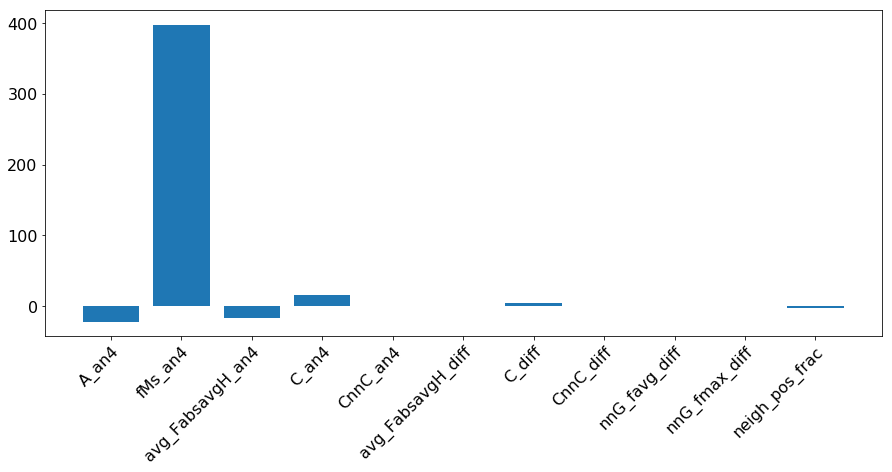

In [21]:
# plotCorrelationMatrixHalf(pd.concat([dfms, X_dfms, geo_topo.C_diff], axis=1), 'dFMs_corr.png')

plotFeatureImportance(lasso.coef_, X.columns, 'A_diff_Lasso')
np.savetxt('_coefs.txt', lasso.coef_, delimiter=',') 
np.savetxt('_feature_names.txt', X.columns, delimiter=',', fmt='%20s') 

### Linear Regression, Forward Selection
- Refs:
    - Best: https://xavierbourretsicotte.github.io/subset_selection.html
    - https://planspace.org/20150423-forward_selection_with_statsmodels/
    - https://github.com/AakkashVijayakumar/stepwise-regression/blob/master/stepwise_regression/step_reg.py
    - https://stackabuse.com/applying-wrapper-methods-in-python-for-feature-selection/

In [28]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 

def forward_selected(data_train, data_test, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data_train.columns)
    remaining.remove(response)
    current_score, best_new_score = 0.0, 0.0
    selected = []
    best_scores = []
    best_tests = []
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            # ----- fit model -----
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            model_tmp = smf.ols(formula, data_train).fit()
            score_train = model_tmp.rsquared_adj
            # ----- calculate test score -----
            y_predict = model_tmp.predict(data_test.loc[:, data_test.columns!='A_diff'])
            r2_test = r2_score(data_test[response], y_predict)
            m = float(X_test.shape[0])
            k = float(X_test.shape[1])
            score_test = 1 - (1-r2_test)*((m-1)/(m-k-1))
            # ----- append results -----
            scores_with_candidates.append((score_train, score_test, candidate))
            
        scores_with_candidates.sort()
        best_new_score, best_new_test, best_candidate = scores_with_candidates.pop()
        best_scores.append(best_new_score)
        best_tests.append(best_new_test)
        selected.append(best_candidate)
        if current_score < best_new_score:
            remaining.remove(best_candidate)
#             formula.append("{} ~ {} + 1".format(response, ' + '.join(selected)))
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data_train).fit()
    return model, selected, best_scores, best_tests


7
[0.28118937204311933, 0.28193893484281496, 0.28229551880001436, 0.28262853799287735, 0.28269928277390133, 0.282745282788209, 0.28267244382421575]
[0.20351249813518812, 0.20428532754787443, 0.20249176743526387, 0.20193374296705635, 0.20537467221258932, 0.20508953437802768, 0.20503509293115318]


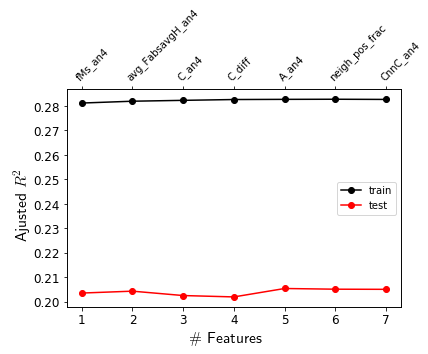

In [39]:
# ----- normalization -----
data =  data / data.max(axis=0) * 10

# ----- X & y -----
y = np.abs(data['A_diff'])
X = data.drop(['A_diff', 'fMs_diff'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

# ----- model & results -----
model, selected, best_scores, best_tests = forward_selected(data_train, data_test, 'A_diff')
print len(selected)
print best_scores
print best_tests
model.summary()

plotForwardSelection(best_scores, best_tests, selected, '|A_diff|_forward')

In [74]:
import xgboost

xgb2 = xgboost.XGBRegressor(
                            learning_rate=0.08, 
                            n_estimators=100, 
                            max_depth=3,
                            gamma=0, 
                            subsample=0.75,
                            colsample_bytree=0.3
                            )

y = np.abs(data['A_diff'])
X = data.drop(['A_diff', 'fMs_diff'], axis=1)
X = X / X.max(axis=0) *10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

xgb2.fit(X_train, y_train)
print xgb2.score(X_train, y_train)
print xgb2.score(X_test, y_test)

0.6111764230174279
0.40470900484245986


0.5520504132139703
0.2982240563175145


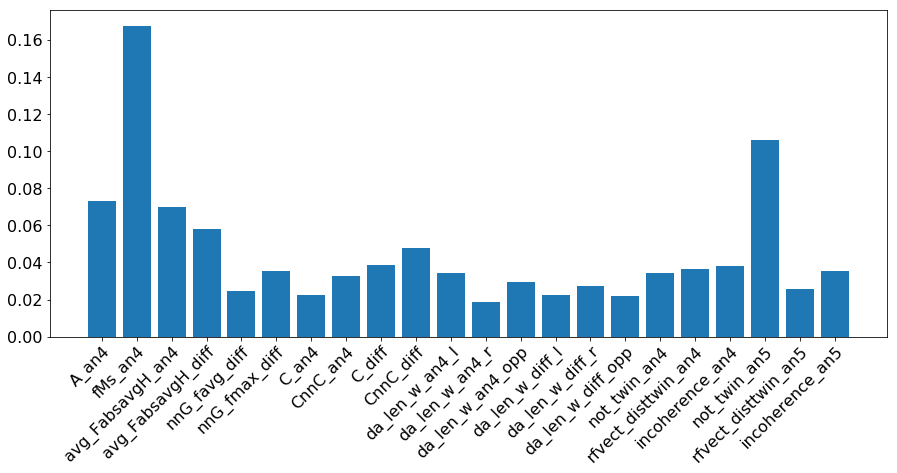

In [60]:
plotFeatureImportance(xgb2.feature_importances_, X.columns)